# Downloading the dataset

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [ ]:
url = "https://www.kaggle.com/datasets/d4rklucif3r/cat-and-dogs"
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: joekanaan
Your Kaggle Key: ··········


100%|██████████| 218M/218M [00:02<00:00, 93.4MB/s]


In [ ]:
import os
dataset_dir = "/content/cat-and-dogs/dataset"
os.listdir(dataset_dir)

['training_set', 'test_set', 'single_prediction']

In [ ]:
os.listdir(dataset_dir + "/training_set")

['dogs', 'cats']

In [ ]:
len(os.listdir(dataset_dir + "/test_set/dogs")), len(os.listdir(dataset_dir + "/training_set/cats"))

(1000, 4000)

#Preparing the data

In [ ]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms as T

In [ ]:
stats = ((0.4893, 0.4564, 0.4182), (0.2600, 0.2528, 0.2555))

train_tfms = T.Compose([
          T.Resize(size = (64, 64)),
          T.RandomHorizontalFlip(),
          T.RandomCrop(64, padding = 4, padding_mode = "reflect"),
          T.ToTensor(),
          T.Normalize(*stats, inplace = True)])

valid_tfms = T.Compose([T.Resize(size = (64, 64)), T.ToTensor(), T.Normalize(*stats)])

In [ ]:
train_ds = ImageFolder(dataset_dir + "/training_set", train_tfms)
val_ds = ImageFolder(dataset_dir + "/test_set", valid_tfms)

In [ ]:
len(train_ds), len(val_ds)

(8000, 2000)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Split the data into batches
batch_size = 100

train_dl = DataLoader(train_ds, batch_size, shuffle = True, 
                      num_workers = 2, pin_memory = True)

val_dl = DataLoader(val_ds, batch_size*2, pin_memory = True)

In [ ]:
len(train_dl), len(val_dl)

(80, 10)

In [ ]:
for images, labels in train_dl:
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)
  break

Images shape: torch.Size([100, 3, 64, 64])
Labels shape: torch.Size([100])


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

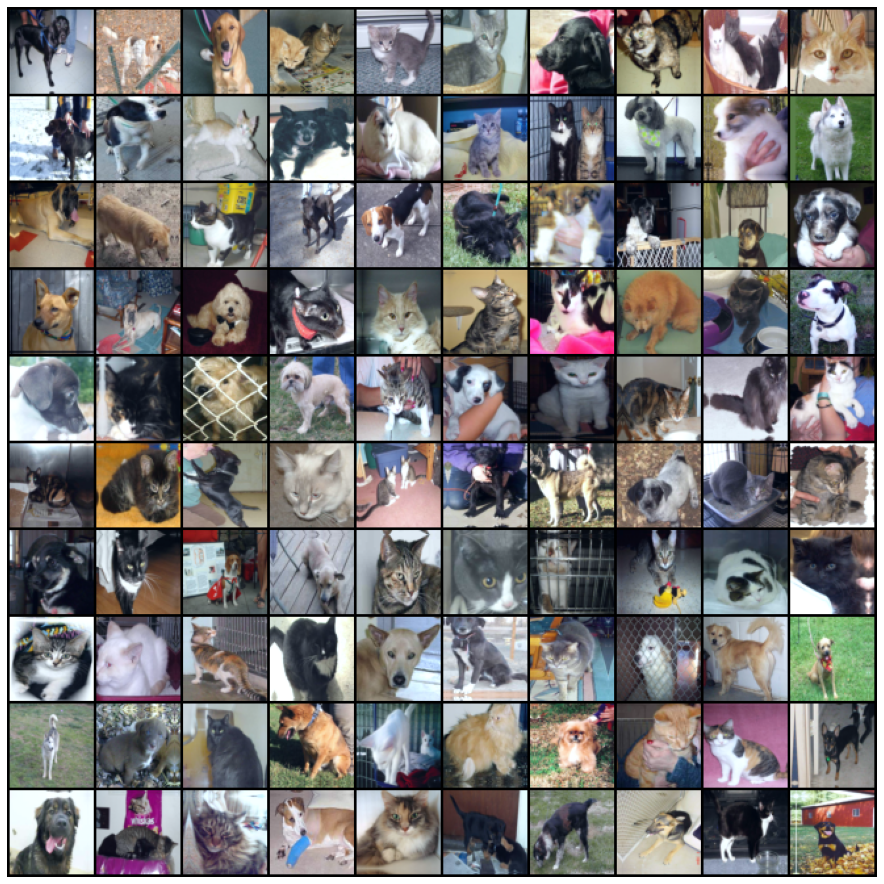

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def plot_batch(dl):
  for images, labels in dl:
    plt.subplots(figsize = (16, 16))
    plt.axis(False)
    plt.imshow(make_grid(denorm(images), nrow = 10).permute(1, 2 , 0))
    break

plot_batch(train_dl)

# Build the model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
  preds = torch.round(outputs)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):

  def __init__(self):
    super().__init__()

  def training_step(self, batch):
    images, labels = batch
    labels = labels.reshape(labels.size(0), 1).type(torch.float32)
    outputs = self(images)
    loss = F.binary_cross_entropy(outputs, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    labels = labels.reshape(labels.size(0), 1).type(torch.float32)
    preds = self(images)
    val_loss = F.binary_cross_entropy(preds, labels)
    val_acc = accuracy(preds, labels)
    return {"val_loss" : val_loss, "val_acc" : val_acc}

  def validation_epoch_end(self, outputs):
    val_losses = [x["val_loss"] for x in outputs]
    avg_loss = torch.stack(val_losses).mean().item()
    val_accs = [x["val_acc"] for x in outputs]
    avg_acc = torch.stack(val_accs).mean().item()
    return {"val_loss" : avg_loss, "val_acc" : avg_acc}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], lr: {:.4f}, train_loss: {:.4f}, val_loss {:.4f}, val_acc {:.4f}".format(
        epoch+1, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]
    ))

In [ ]:
def conv_block(in_channels, out_channels, pool = False):

  network = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace = True)]
            
  if pool:
    network.append(nn.MaxPool2d(2))

  return nn.Sequential(*network)


class ResNet9(ImageClassificationBase):

  def __init__(self, in_channels):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64, pool = True)
    self.conv2 = conv_block(64, 128, pool = True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool = True)
    self.conv4 = conv_block(256, 512, pool = True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.classifier = nn.Sequential(
        nn.MaxPool2d(4),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    return self.classifier(out)

model = ResNet9(3)

In [ ]:
for images, labels in train_dl:
  print("Images shape:", images.shape)
  break

Images shape: torch.Size([100, 3, 64, 64])


In [ ]:
for images, labels in train_dl:
  outputs = model(images)
  print(outputs.dtype)
  labels = labels.reshape(labels.size(0), 1).type(torch.float32)
  print(labels.dtype)
  acc = accuracy(outputs, labels)
  print(acc)
  break

torch.float32
torch.float32
tensor(0.4900)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(model, device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

In [ ]:
@torch.no_grad()
def evaluate(model, val_dl):
  outputs = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group["lr"]

def fit(epochs, max_lr, model, train_dl, val_dl, weight_decay = 0,
        grad_clip = None, opt = torch.optim.SGD):
  
  torch.cuda.empty_cache()
  history = []

  optimizer = opt(model.parameters(), max_lr, weight_decay = weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs,
                                            steps_per_epoch = len(train_dl))

  for epoch in range(epochs):

    # Training phase
    model.train()
    train_losses = []
    lrs = []
    for batch in train_dl:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      
      if grad_clip is not None:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      
      optimizer.step()
      optimizer.zero_grad()

      # Record & Update Learning Rate
      lrs.append(get_lr(optimizer))
      sched.step()

    # Validation phase
    result = evaluate(model, val_dl)
    result["train_loss"] = torch.stack(train_losses).mean().item()
    result["lrs"] = lrs
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [ ]:
for images, labels in val_dl:
  print(torch.max(images))
  break

tensor(2.2771, device='cuda:0')


In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.8156097531318665, 'val_acc': 0.48900002241134644}]

In [ ]:
epochs = 8
max_lr = 0.005
opt = torch.optim.Adam
weight_decay = 0
grad_clip = None

In [ ]:
history = fit(epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt)

Epoch [1], lr: 0.0020, train_loss: 0.6910, val_loss 0.7545, val_acc 0.6000
Epoch [2], lr: 0.0047, train_loss: 0.5683, val_loss 0.8529, val_acc 0.6195
Epoch [3], lr: 0.0049, train_loss: 0.4849, val_loss 0.8223, val_acc 0.6370
Epoch [4], lr: 0.0041, train_loss: 0.4126, val_loss 1.1062, val_acc 0.6080
Epoch [5], lr: 0.0028, train_loss: 0.3644, val_loss 0.8961, val_acc 0.6460
Epoch [6], lr: 0.0014, train_loss: 0.2756, val_loss 0.8647, val_acc 0.6585
Epoch [7], lr: 0.0004, train_loss: 0.2189, val_loss 0.9958, val_acc 0.6540
Epoch [8], lr: 0.0000, train_loss: 0.1882, val_loss 1.0321, val_acc 0.6590
